In [35]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))

# Verifique se os caminhos foram adicionados
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_pre_processing import read_mesh
    from fem_processing import boundary_conditions, matrices_assembly
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Modules imports were successful!


## Physics Constants

In [36]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0

# Project 3: 

# 3-noded Linear Triangular Elements, $P_1$
# Pre-processor module
## Geometry and mesh Domain

In [37]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'BGT', 'value': None, 'name': 'truncated_domain'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

R_DOMAIN = 'R4'

BGT = ps.apply_bgt_constants(R_DOMAIN)

# Criar geometria coaxial
ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, R=R_DOMAIN, h=1/20, view_mesh=False)

# Create mesh from file geometry
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='circular_pec')

Model circular_pec_domain_Triangle1 (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 5294 nodes in total
Info     : 10273 2-D elements in total


## Mesh Data Dictionaries

In [38]:
cell_data = mesh_data['cell']; cell_data[1]

{'Tag': 318,
 'conn': [325, 3478, 3114],
 'material': {'tag': 201,
  'name': 'free_space',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1}}

In [39]:
nodes_data = mesh_data['nodes']; nodes_data

{1: {'xg': (0.4996540966666775, 0.0),
  'bc': {'type': 'Dirichlet', 'value': None}},
 2: {'xg': (1.498962290000033, 0.0), 'bc': {'type': 'BGT', 'value': None}},
 3: {'xg': (0.4990329872612327, 0.02490570097234618),
  'bc': {'type': 'Dirichlet', 'value': None}},
 4: {'xg': (0.4971712032207434, 0.04974948244787919),
  'bc': {'type': 'Dirichlet', 'value': None}},
 5: {'xg': (0.494073373233681, 0.07446957887141109),
  'bc': {'type': 'Dirichlet', 'value': None}},
 6: {'xg': (0.4897471989934941, 0.09900453218828131),
  'bc': {'type': 'Dirichlet', 'value': None}},
 7: {'xg': (0.4842034360509852, 0.123293344638764),
  'bc': {'type': 'Dirichlet', 'value': None}},
 8: {'xg': (0.4774558670743166, 0.1472756304081096),
  'bc': {'type': 'Dirichlet', 'value': None}},
 9: {'xg': (0.4695212675831257, 0.1708917657551949),
  'bc': {'type': 'Dirichlet', 'value': None}},
 10: {'xg': (0.4604193642419404, 0.1940830372465379),
  'bc': {'type': 'Dirichlet', 'value': None}},
 11: {'xg': (0.4501727858165822, 0.2

In [40]:
conn = {key: cell['conn'] for key, cell in cell_data.items()}; conn[1]

[325, 3478, 3114]

In [41]:
conn_py = {key: [(vertex - 1) for vertex in cell['conn']] for key, cell in mesh_data['cell'].items()}; conn_py[1]

[324, 3477, 3113]

## Figure 1: Coaxial meshed domain 

In [42]:
graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, model='circular_pec', Numbering=False)

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p32_circular_pec_scatterer_abc\pre_processing\pictures\circular_pec_meshed_domain_Triangle1.svg


<figure>
    <img src="pre_processing/pictures/circular_pec_meshed_domain_Triangle1.svg" alt="Fig.1" style="width:90%;" />
    <figcaption>Figure 1: Coaxial meshed domain.</figcaption>
</figure>

# Processor module
## `apply_physics()`

In [43]:
mesh_data = ps.apply_physics(FINITE_ELEMENT, mesh_data); cell_data[1]

{'Tag': 318,
 'conn': [325, 3478, 3114],
 'material': {'tag': 201,
  'name': 'free_space',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'stiffness_a_value': array([[1., 0.],
        [0., 1.]]),
 'mass_a_value': -39.53309720435509,
 'source': {'type': 'free_source', 'value': 0},
 'abc': {'type': None, 'conn_idx': None}}

## Imposition of Boundary Conditions

### $Dirichlet$ nodes

In [44]:
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
dirichlet_nodes[1]

{'xg': (0.4996540966666775, 0.0),
 'bc': {'type': 'Dirichlet', 'value': (1+5.66553889764798e-16j)}}

### $BGT$ Nodes

In [45]:
bgt_nodes = {key: value 
             for key, value in nodes_data.items() if value['bc']['type'] == 'BGT'}

In [46]:
Nn = len(nodes_data); Nd = len(dirichlet_nodes); N_bgt = len(bgt_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes; {N_bgt} BGT nodes.")

The entire domain has 5294 nodes: 5168 free nodes; 126 Dirichlet nodes; 189 BGT nodes.


### $\Gamma_a$ Boundary

In [47]:
gamma_a_cells = {key: value for key, value in cell_data.items() if value['abc']['type'] == 'BGT'}

## Figure 2: `plot_coordinates()`

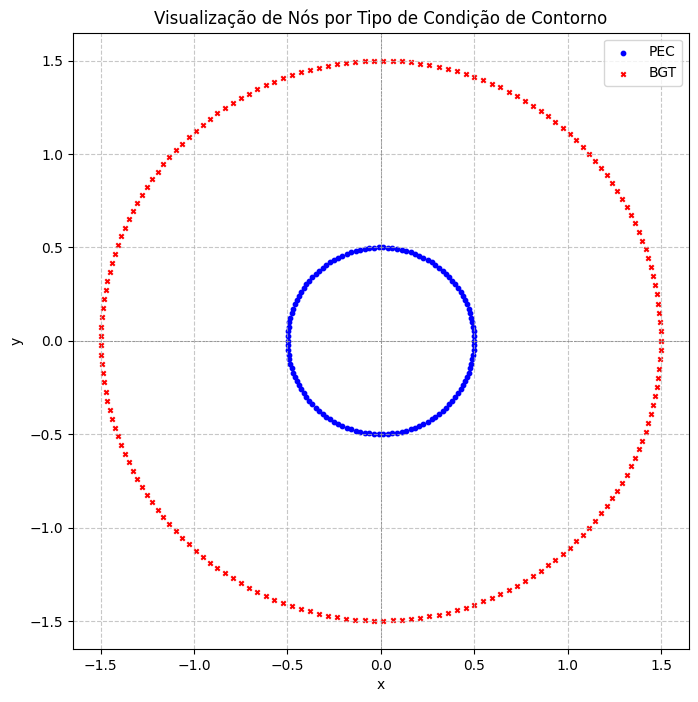

In [48]:
ps.plot_coordinates(mesh_data)

## ``global_nodes_coordinates()``

In [49]:
nodes_coord = {key: value['xg'] for key, value in nodes_data.items()}; nodes_coord[1]

(0.4996540966666775, 0.0)

## $x_g, y_g$ global coordinate

In [50]:
xg = {key: value['xg'][0] for key, value in nodes_data.items()}; xg[1]

0.4996540966666775

## $a_e = (x_e, y_e)$ global element coordinate

In [51]:
ai = {key: [nodes_data[id]['xg'] for id in node_ids] for key, node_ids in conn.items()}
xi = {key: [coord[0] for coord in coords] for key, coords in ai.items()}
print("'ae_1' global coordinates: ", ai[1]) 
print("'xe_1' global coordinates: ", xi[1])

'ae_1' global coordinates:  [(-0.489264008592118, 0.190713943948697), (-0.5167807285011264, 0.200750120515042), (-0.5139895440490528, 0.1761323616804444)]
'xe_1' global coordinates:  [-0.489264008592118, -0.5167807285011264, -0.5139895440490528]


In [52]:
print("'Node 2' global coordinates: ", nodes_data[2]['xg'])

'Node 2' global coordinates:  (1.498962290000033, 0.0)


## `map_to_physical_coordinates()`

In [53]:
xi_master = (0, 1)
xg_1, yg_1 = matrices_assembly.isomapping_to_global_coordinates(ai[1], xi_master, FINITE_ELEMENT)
print(f"'e_1' Master coordinates: {xi_master} --> Global coordinates: ({xg_1}, {yg_1})")

'e_1' Master coordinates: (0, 1) --> Global coordinates: (-0.5139895440490528, 0.1761323616804444)


## Material Proprieties, $k_a$

In [54]:
ka = {key: value['stiffness_a_value'] for key, value in cell_data.items()}

In [55]:
ma = {key: value['mass_a_value'] for key, value in cell_data.items()}

## Jacobian Matrix Transform

In [56]:
Je = matrices_assembly.jacobian(FINITE_ELEMENT, mesh_data, e=1, xik=(0, 0)) 
Jdet, Jinv = np.linalg.det(Je), np.linalg.inv(Je)
print("Jacobian matrix for element e_1:\n", Je)
print("Determinant of the Jacobian matrix for element e_1:", Jdet)

Jacobian matrix for element e_1:
 [[-0.02751672  0.01003618]
 [-0.02472554 -0.01458158]]
Determinant of the Jacobian matrix for element e_1: 0.0006493871546488925


## Local Elements $e_1$

In [57]:
Ae, fe, Me, Pe, Qe = matrices_assembly.local_matrices(FINITE_ELEMENT, mesh_data, e=1)
print("Local stiffness matrix for element e_1:\n", Ae)
print("Local load vector for element e_1:\n", fe)

Local stiffness matrix for element e_1:
 [[ 0.47261849+0.j -0.22325075+0.j -0.24936774+0.j]
 [-0.22325075+0.j  0.6344248 +0.j -0.41117405+0.j]
 [-0.24936774+0.j -0.41117405+0.j  0.66054179+0.j]]
Local load vector for element e_1:
 [[0.]
 [0.]
 [0.]]


In [58]:
free_nodes = {key: value for key, value in nodes_data.items() if value['bc']['type'] != 'Dirichlet'}

## Mapping Global nodes to reduced system

This code creates a dictionary called ``global_to_reduced``, which maps the global indices of the mesh nodes to the reduced indices, i.e. the indices that correspond only to the nodes that are not in the _Dirichlet boundary conditions_.

In [59]:
mapping = {global_id: idx + 1 for idx, global_id in enumerate(free_nodes.keys())}

## Reduced Global matrix $A_{gr}$ with boundary conditions

In [60]:
Sgr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (5168, 5168)


## Global matrix $A_{g}$ with boundary conditions

In [61]:
Ag, fg, Mg, Pg, Qg = matrices_assembly.global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (5168, 5168)


# ABC Formulation

In [62]:
Agr = Sgr + Mgr + BGT['2']['ALPHA'] * Pgr - BGT['2']['BETA'] * Qgr

## Global Potential Solution

In [63]:
ezr = spsolve(Agr.tocsr(), fgr.toarray())
ez_h = boundary_conditions.global_potentials_solution(mesh_data, ezr)

## Solution at each element

In [64]:
u_for_cell = {
    e: [ez_h[node] for node in cell['conn']]
    for e, cell in mesh_data['cell'].items()}
u_for_cell[1]

[(0.8861633381190651-0.35009125770278693j),
 (0.7695020108968296-0.4832331117062812j),
 (0.8331582311440547-0.4013872307630729j)]

## Interpolate Solution at element, $e_n$

In [65]:
xi_master = (0, 0.5)
e = 1
u_at_node = matrices_assembly.isomapping_to_global_coordinates(u_for_cell[e], xi_master, FINITE_ELEMENT)
print(f"Element e_{e}: Potential 'u' interpolate at xi = {xi_master} --> u(xi): {u_at_node}")

Element e_1: Potential 'u' interpolate at xi = (0, 0.5) --> u(xi): [0.85966078-0.37573924j]


# $z$-component of electriz field scattered, $E_z^s$

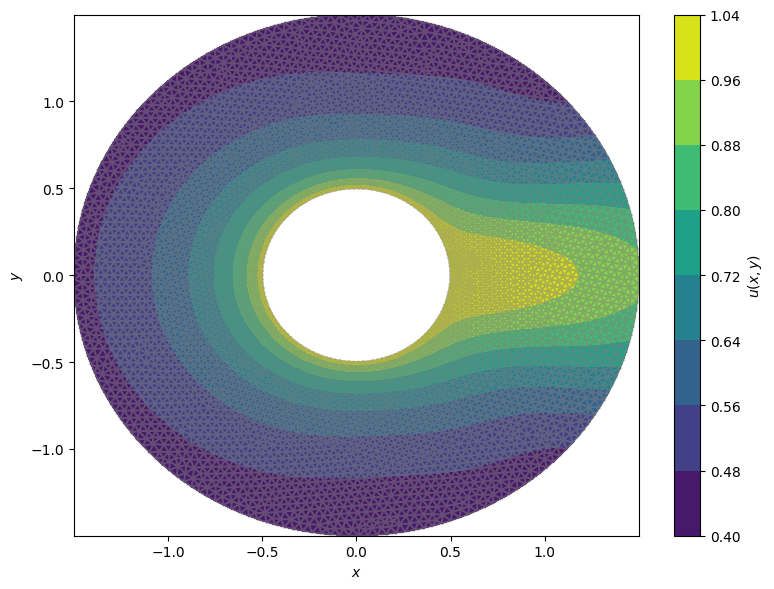

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p32_circular_pec_scatterer_abc\pos_processing\pictures\analytical_solution.svg


In [66]:
ez = ps.ez_at_omega(mesh_data)
graph_results.fem_solution(FINITE_ELEMENT, mesh_data, ez_h, type='abs')
ps.plot_ez_domain(FINITE_ELEMENT, mesh_data, ez, type='abs')

## Figure 2: Numerical solution to scalar Field Distribution on a Triangular Mesh
<figure>
    <img src="pos_processing/pictures/fem_solution_Triangle1.svg" alt="Fig.2" style="width:70%;" />
    <figcaption>Figure 2: Post-Processor: Numerical Solution to Scalar Field Distribution.</figcaption>
</figure>

## Figure 3: Analytical Scalar Field Distribution
<figure>
    <img src="pos_processing/pictures/analytical_solution.svg" alt="Fig.3" style="width:70%;" />
    <figcaption>Figure 3: Post-Processor: Analytical Solution to Scalar Field Distribution.</figcaption>
</figure>

# Error evaluation

In [67]:
u_exact = np.array(list(ez.values()))
u_approx = np.array(list(ez_h.values()))
error = ps.calculate_error(u_exact, u_approx)
print(f"Erro entre a solução exata e a solução aproximada: {error:.4}")

Erro entre a solução exata e a solução aproximada: 0.2374


# $E_z$ profile

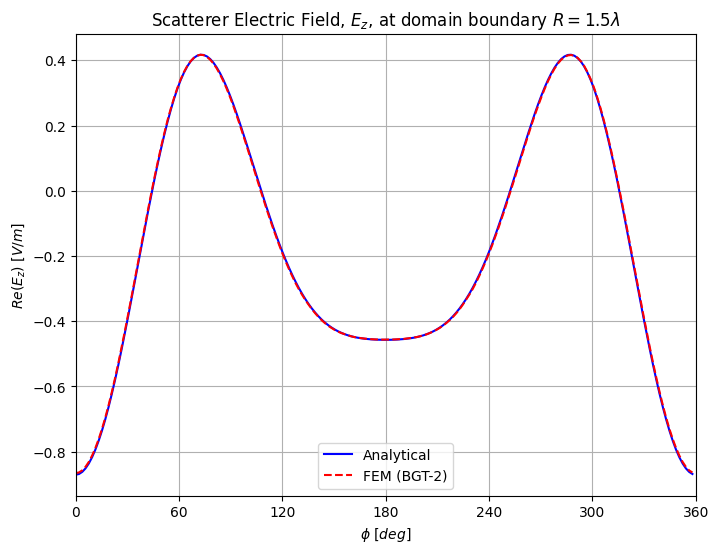

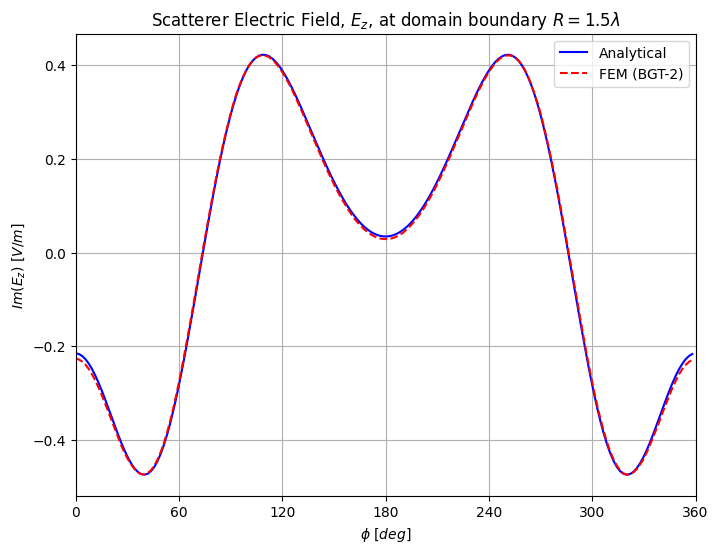

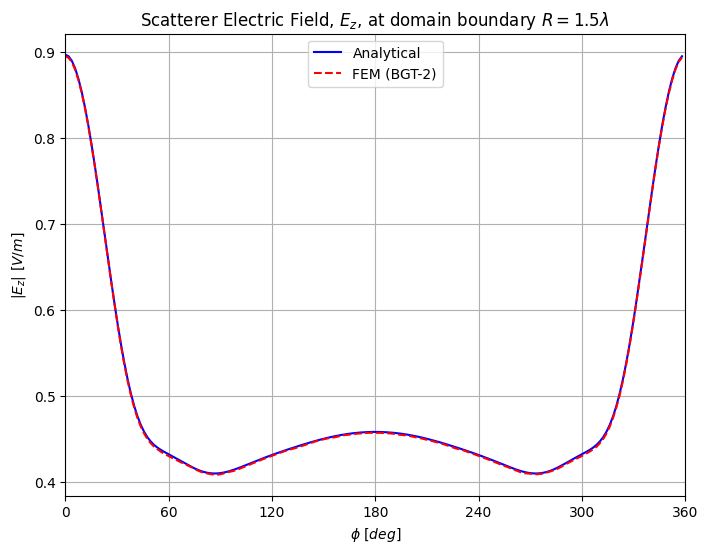

In [68]:
ez_bgt = ps.ez_at_contour(mesh_data, contour='BGT')
ezh_bgt = {key: ez_h[key] for key in bgt_nodes.keys()}
ps.plot_ez_profile(ez_bgt, ezh_bgt)

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.